Import libraries we need. See the conda environment yml file for details on software versions.

In [80]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
import os
import scipy.io as sio
from scipy.stats import ttest_ind

Read in the data

In [2]:
data_path = '/home/mcn26/palmer_scratch/xiang/'

In [3]:
df = pd.read_csv(data_path + 'GSE136447_555sample_gene_count_matrix.txt.gz', sep="\t", compression='gzip', index_col=0)

Make an adata object out of the data. Rows and columns are switched so we fix that with T.

In [4]:
adata = sc.AnnData(df.T)

Write the data into a mtx format.

In [5]:
# Assuming 'adata' is your AnnData object
adata.write("./mydata.h5ad")  # Save as a complete h5ad file first


# Save the main matrix
sio.mmwrite("./matrix.mtx", adata.X)

# Save genes (rows) and barcodes (columns) as text files
genes = adata.var_names
with open("./genes.txt", "w") as f:
    for gene in genes:
        f.write(gene + "\n")

barcodes = adata.obs_names
with open("./barcodes.txt", "w") as f:
    for barcode in barcodes:
        f.write(barcode + "\n")

Sanity check, to make sure genes and cell barcodes are reasonable-looking values:

In [6]:
barcodes


Index(['D6N1B23', 'D6N1B6', 'D6N1S1', 'D6N1S15', 'D6N1S19', 'D6N1S3',
       'D6N1S33', 'D6N1S34', 'D6N1S35', 'D6N1S39',
       ...
       'D14_2S1', 'D14_3B5', 'D14_3B6', 'D14_3S10', 'D14_3S15', 'D14_3S16',
       'D14_3S9', 'D14_2S2', 'D14_2B1', 'D14_2B3'],
      dtype='object', length=555)

In [7]:
genes

Index(['ENSG00000146469.12|VIP', 'ENSG00000159214.12|CCDC24',
       'ENSG00000244171.4|PBX2P1', 'ENSG00000136295.14|TTYH3',
       'ENSG00000141736.13|ERBB2', 'ENSG00000250682.5|LINC00491',
       'ENSG00000284348.1|AC245128.32', 'ENSG00000268324.2|LRRC2-AS1',
       'ENSG00000273350.1|AC004832.5', 'ENSG00000214428.3|NPM1P10',
       ...
       'ENSG00000232053.6|AC078845.1', 'ENSG00000253422.1|AC008677.3',
       'ENSG00000130193.7|THEM6', 'ENSG00000257323.1|AC123904.2',
       'ENSG00000277704.1|AL445675.2', 'ENSG00000155367.15|PPM1J',
       'ENSG00000172893.15|DHCR7', 'ENSG00000093100.13|AC016026.1',
       'ENSG00000230188.1|AL158156.1', 'ENSG00000201377.1|RNY4P23'],
      dtype='object', name='gene_id', length=64837)

Let us perform some basic QC. Based on [scanpy pbmc3k tutorial.](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html)

Set some settings... (not important for analysis, just convienient)

In [75]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=300, facecolor='white')

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.24.3 scipy==1.10.1 pandas==2.0.2 scikit-learn==1.2.2 statsmodels==0.14.0 python-igraph==0.10.4 pynndescent==0.5.10


In [9]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [10]:
adata

AnnData object with n_obs × n_vars = 555 × 64837

Show those genes that yield the highest fraction of counts in each single cell, across all cells.

normalizing counts per cell
    finished (0:00:00)


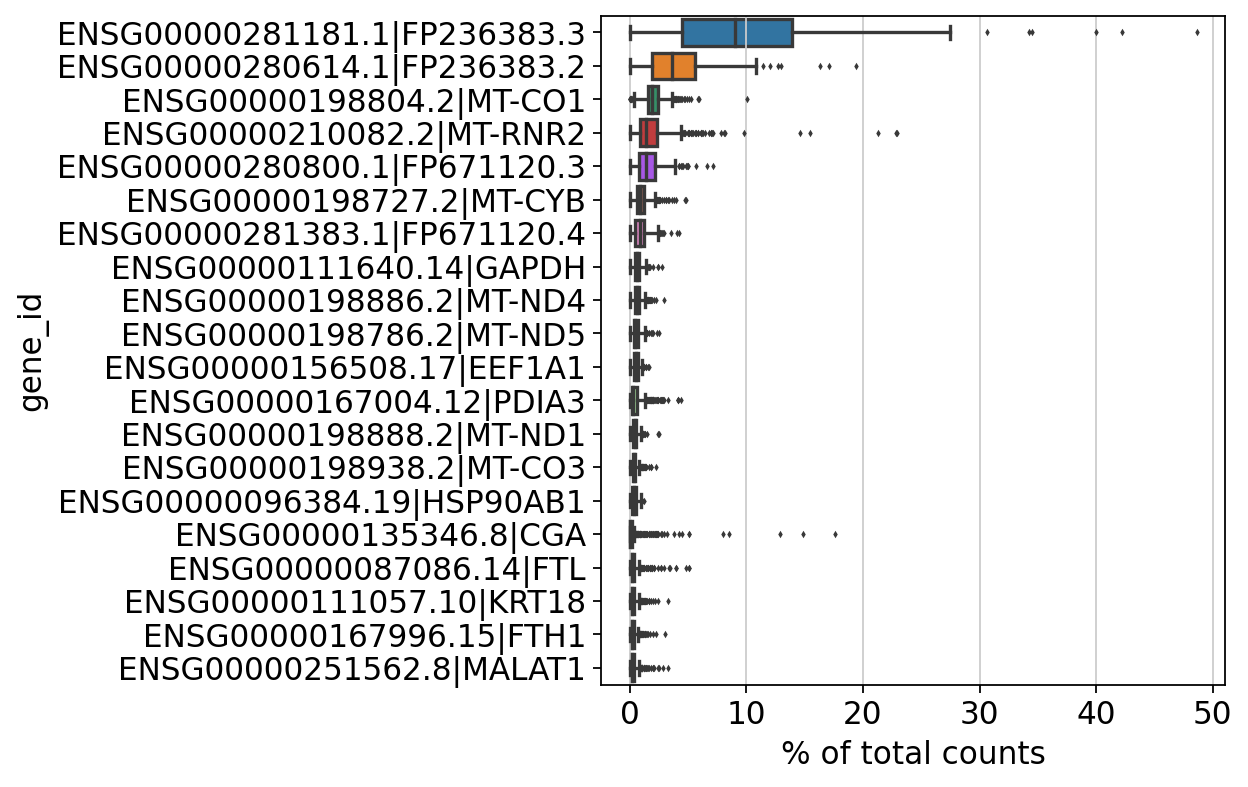

In [11]:
sc.pl.highest_expr_genes(adata, n_top=20, )

basic filtering

In [12]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 22568 genes that are detected in less than 3 cells


In [13]:
adata

AnnData object with n_obs × n_vars = 555 × 42269
    obs: 'n_genes'
    var: 'n_cells'

In [14]:
adata.var['mt'] = adata.var_names.str.contains('\|MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

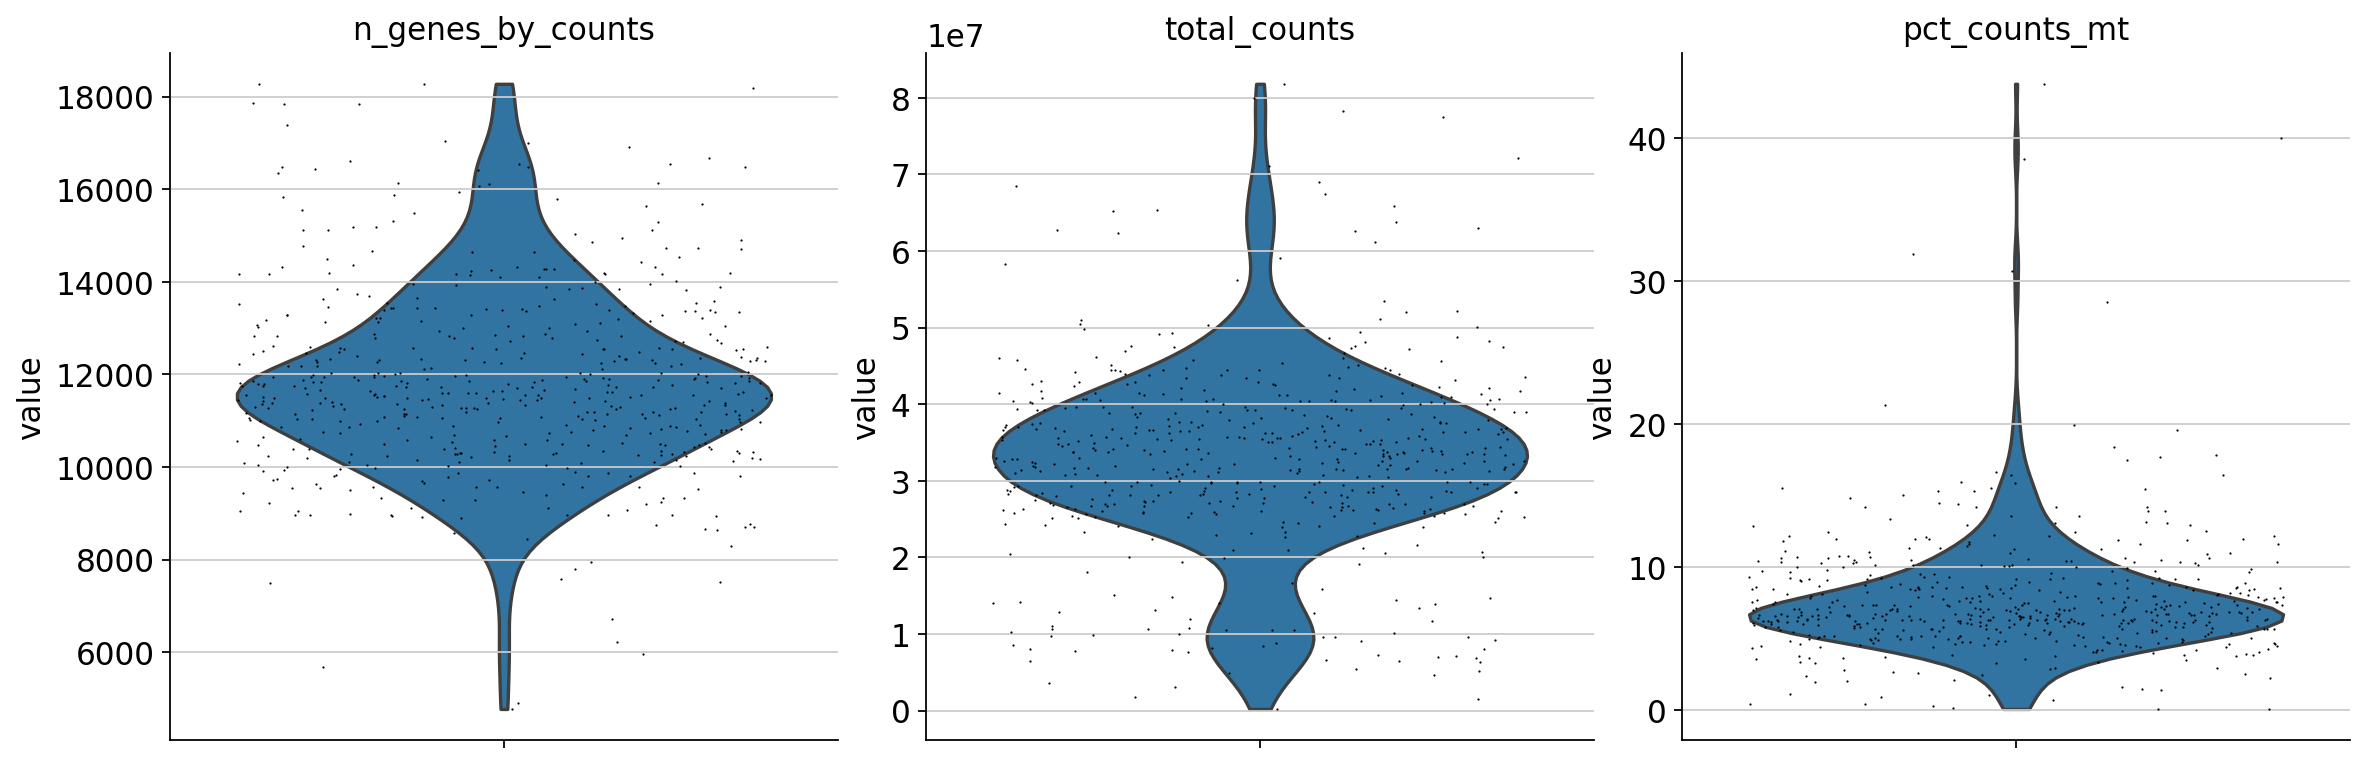

In [15]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

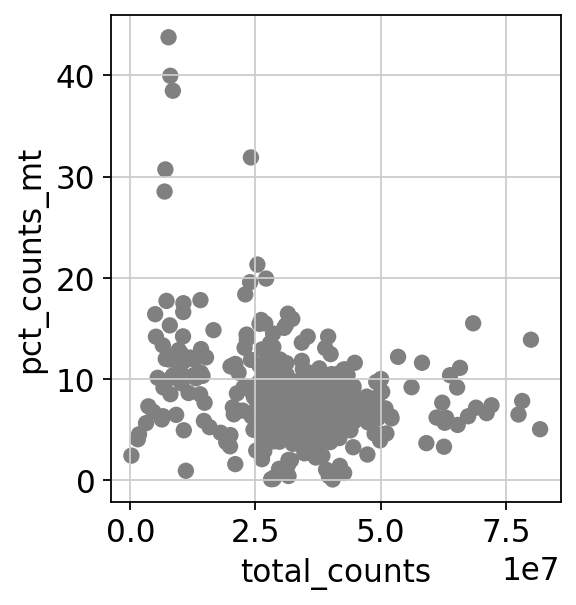

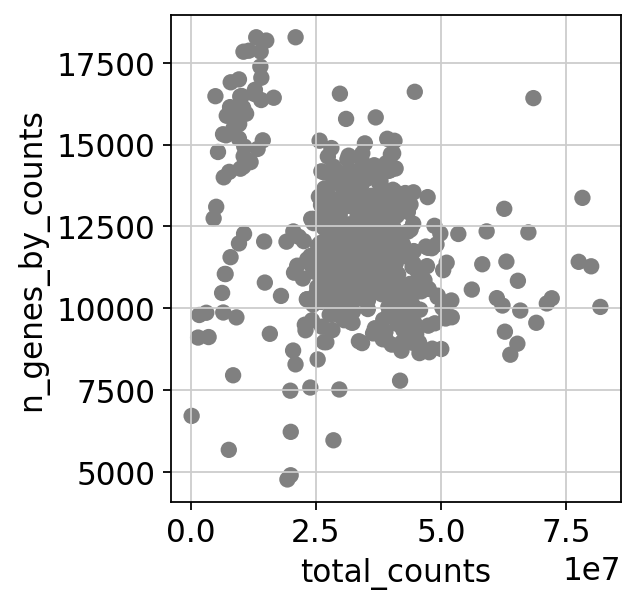

In [16]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

OK, it actually looks quite good. Let's filter

In [17]:
adata = adata[adata.obs.pct_counts_mt < 20, :]
adata = adata[adata.obs.n_genes_by_counts < 15000, :]

I'm curious: Has it already been log-transformed?

In [18]:
# Sample random indices
num_samples = 10  # Number of values you want to sample
random_rows = np.random.choice(adata.X.shape[0], num_samples)
random_cols = np.random.choice(adata.X.shape[1], num_samples)

# Get the values at those indices
sampled_values = adata.X[random_rows, random_cols].flatten()

print(sampled_values)

[  0 633   0  76   0   0   0   0  84   0]


Ok no, still looks like raw counts.

Normalize total counts per cell to 10^4

In [19]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell


/gpfs/gibbs/project/reilly/mcn26/conda_envs/parse_scanpy/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)


Scale to log (1+counts)

In [20]:
sc.pp.log1p(adata)

Extract highly var genes.

In [21]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


Plot dispersion of genes as a function of mean.

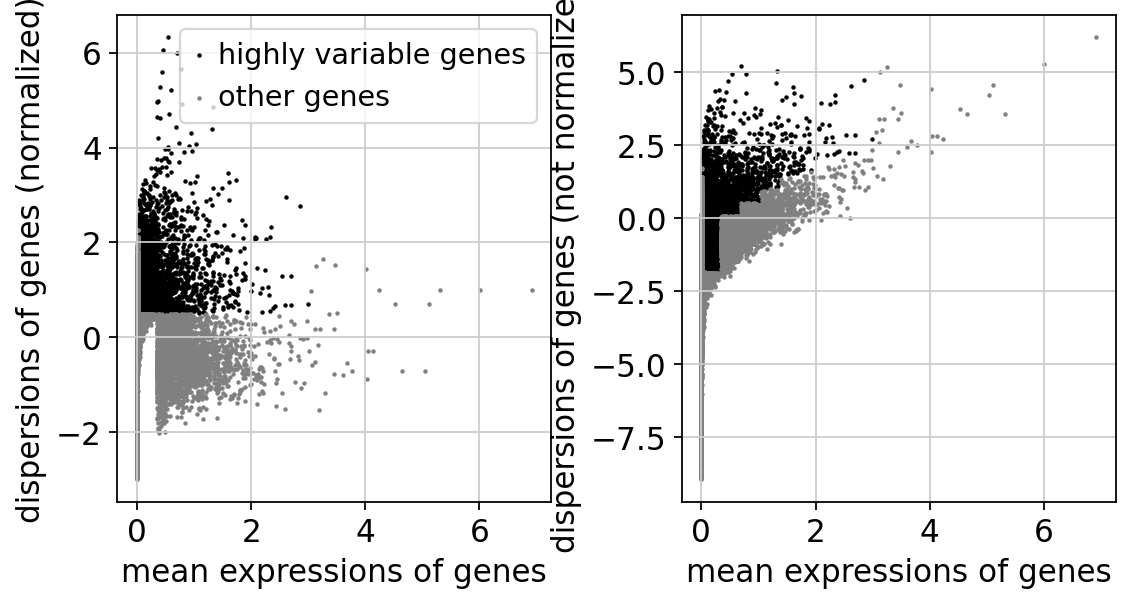

In [22]:
sc.pl.highly_variable_genes(adata)

Save a backup

In [23]:
adata.raw = adata

Regress out the effect of total counts

In [24]:
sc.pp.regress_out(adata, ['total_counts']) #'pct_counts_mt' : it's all zero so we skip this

regressing out ['total_counts']
    finished (0:02:03)


Scale each gene to variance = 1, and kill all values >10 (that is : those values more than 10 standard deviations above the mean)

In [25]:
sc.pp.scale(adata, max_value=10)

See if h2aj was filtered out

In [26]:
print( [s for s in adata.var_names if "H2AJ" in s])
print( [s for s in adata.var_names if "H2AFJ" in s])

['ENSG00000276368.1|HIST1H2AJ']
['ENSG00000246705.4|H2AFJ']


Perfect! It is still there! (that HIST1 is not the gene were are interested in : it's the H2AJF). Is it one of the highly variable genes?

In [27]:
high_var_only=adata[:, adata.var.highly_variable]

In [28]:
print( [s for s in high_var_only.var_names if "H2AJ" in s])
print( [s for s in high_var_only.var_names if "H2AFJ" in s])

[]
['ENSG00000246705.4|H2AFJ']


It is. We're not going to apply this filtering in place (`adata=adata[:, adata.var.highly_variable]`) since highly variable genes are automagically used by neighbor detection, pca et al below

PCA

In [29]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


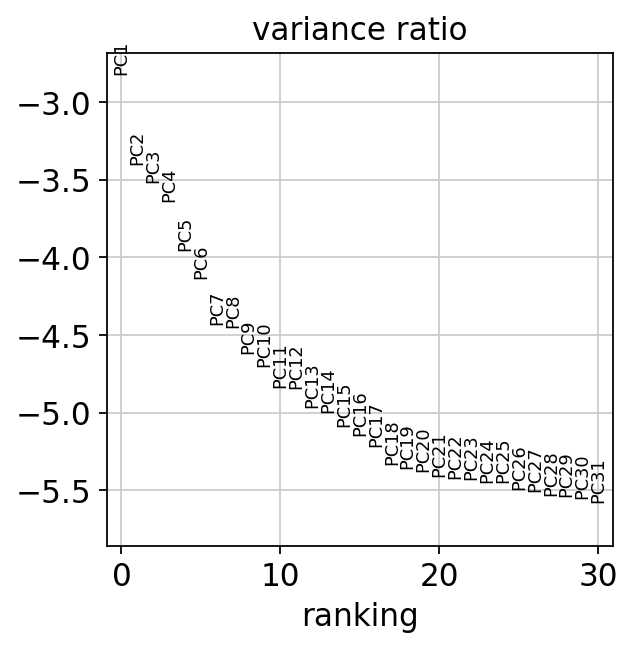

In [30]:
sc.pl.pca_variance_ratio(adata, log=True)

Looks like two elbows?

Compute neighbors. Using default  n_neighbors

In [31]:
sc.pp.neighbors(adata, n_pcs=18)# n_neighbors=10

computing neighbors
    using 'X_pca' with n_pcs = 18
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


Compute UMAP

In [32]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


Let's take some marker genes, and get their names in this dataset...print( [s for s in high_var_only.var_names if "H2AJ" in s])

> Hypoblast (primitive endoderm): GATA4, GATA6, SOX17, PDGFRα, and AFP.

> Epiblast: NANOG, OCT4 (POU5F1), and SOX2.

> Trophoblast: CGB, KRT7, HLA-G, GATA3, and ITGA6.


https://www.nature.com/articles/s41586-019-1875-y
> We verified embryonic development using morphological observations and staining for specific lineage markers—OCT4 for the inner cell mass (ICM) and epiblast (EPI), GATA6 for primitive endoderm/hypoblast (PrE) and CK7 for trophoblast (TrB)

Let us find what they are called in this dataset...

In [47]:
def find(name):
    print(name)
    print( [s for s in high_var_only.var_names if name in s])
    print("")
#ENSG00000246705.4|H2AFJ
print("Epiblast")
find("NANOG")
find("POU5F1")
find("SOX2")

print("Hypoblast")
find("GATA4")
find("GATA6")
find("SOX17")
find("PDGFRA")

print("Trophoblast")
find("KRT7")
find("CGB")
find("HLA-G")
find("GATA3")
find("ITGA6")

Epiblast
NANOG
['ENSG00000255192.5|NANOGP8', 'ENSG00000111704.10|NANOG', 'ENSG00000176654.12|NANOGP1']

POU5F1
['ENSG00000204531.17|POU5F1']

SOX2
['ENSG00000227640.2|SOX21-AS1', 'ENSG00000165661.16|QSOX2']

Hypoblast
GATA4
['ENSG00000136574.17|GATA4']

GATA6
['ENSG00000266010.2|GATA6-AS1', 'ENSG00000141448.8|GATA6']

SOX17
['ENSG00000164736.5|SOX17']

PDGFRA
['ENSG00000134853.11|PDGFRA']

Trophoblast
KRT7
['ENSG00000135480.15|KRT7']

CGB
['ENSG00000275395.5|FCGBP', 'ENSG00000104827.12|CGB3', 'ENSG00000196337.11|CGB7', 'ENSG00000164265.8|SCGB3A2', 'ENSG00000213030.5|CGB8', 'ENSG00000267631.4|CGB1', 'ENSG00000104818.14|CGB2']

HLA-G
['ENSG00000204632.11|HLA-G']

GATA3
['ENSG00000197308.9|GATA3-AS1']

ITGA6
['ENSG00000091409.14|ITGA6']



Epiblast

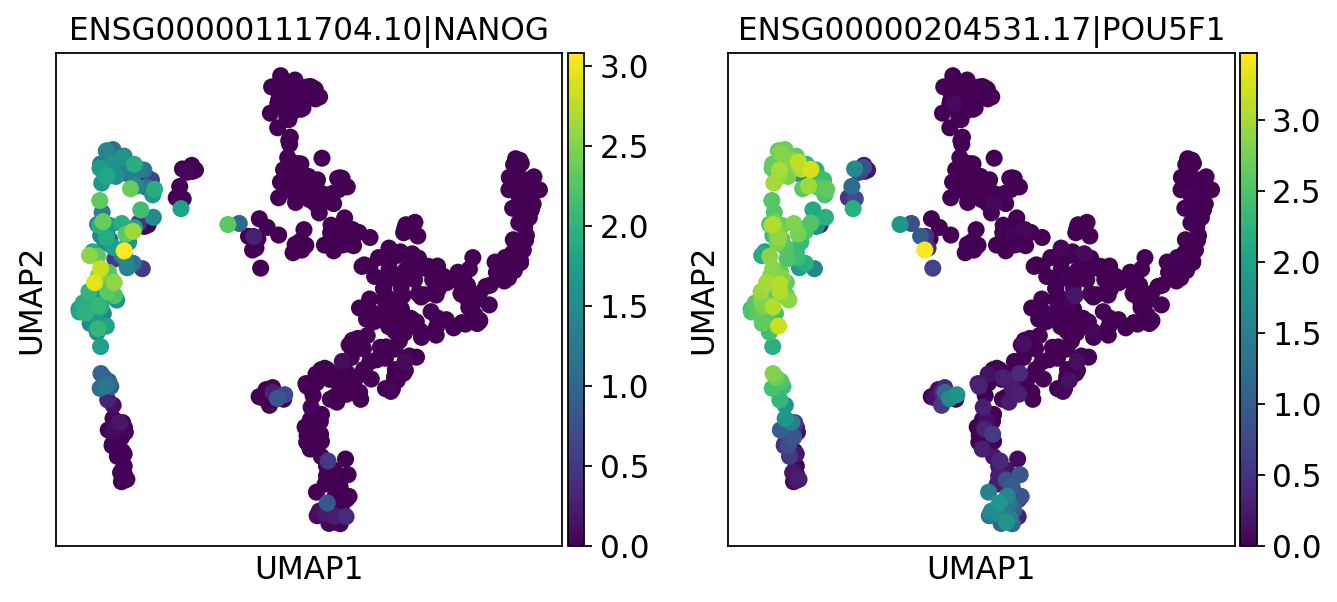

In [46]:
sc.pl.umap(adata,color=['ENSG00000111704.10|NANOG','ENSG00000204531.17|POU5F1'])

Hypoblast

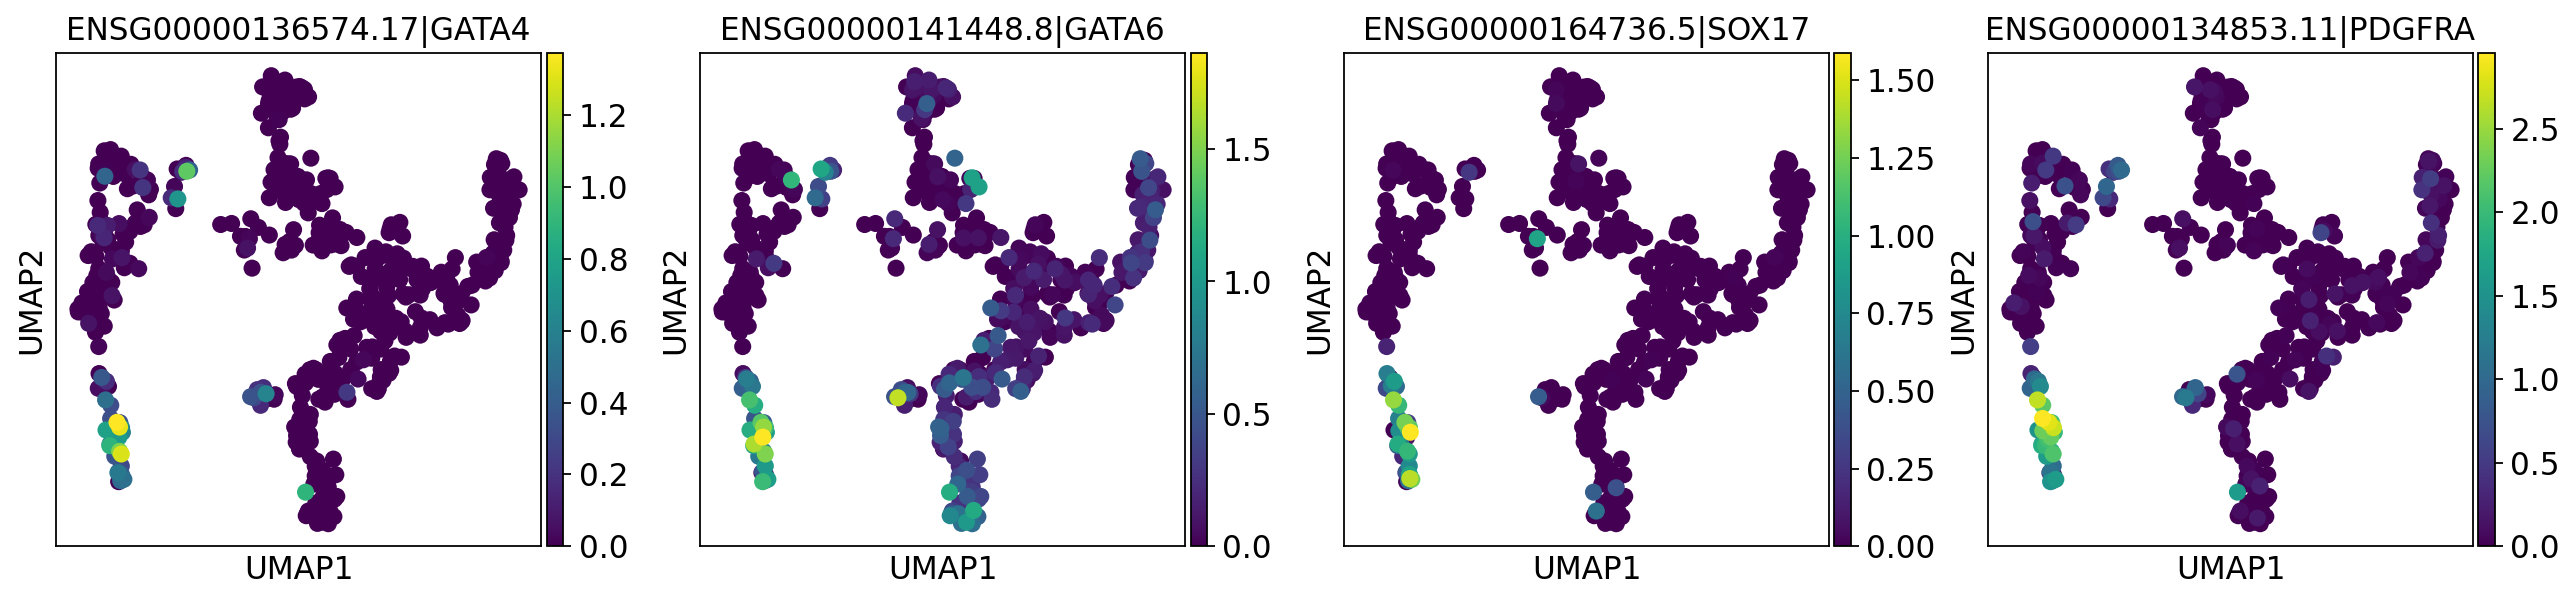

In [49]:
sc.pl.umap(adata,color=['ENSG00000136574.17|GATA4','ENSG00000141448.8|GATA6','ENSG00000164736.5|SOX17','ENSG00000134853.11|PDGFRA'])

Trophoblast

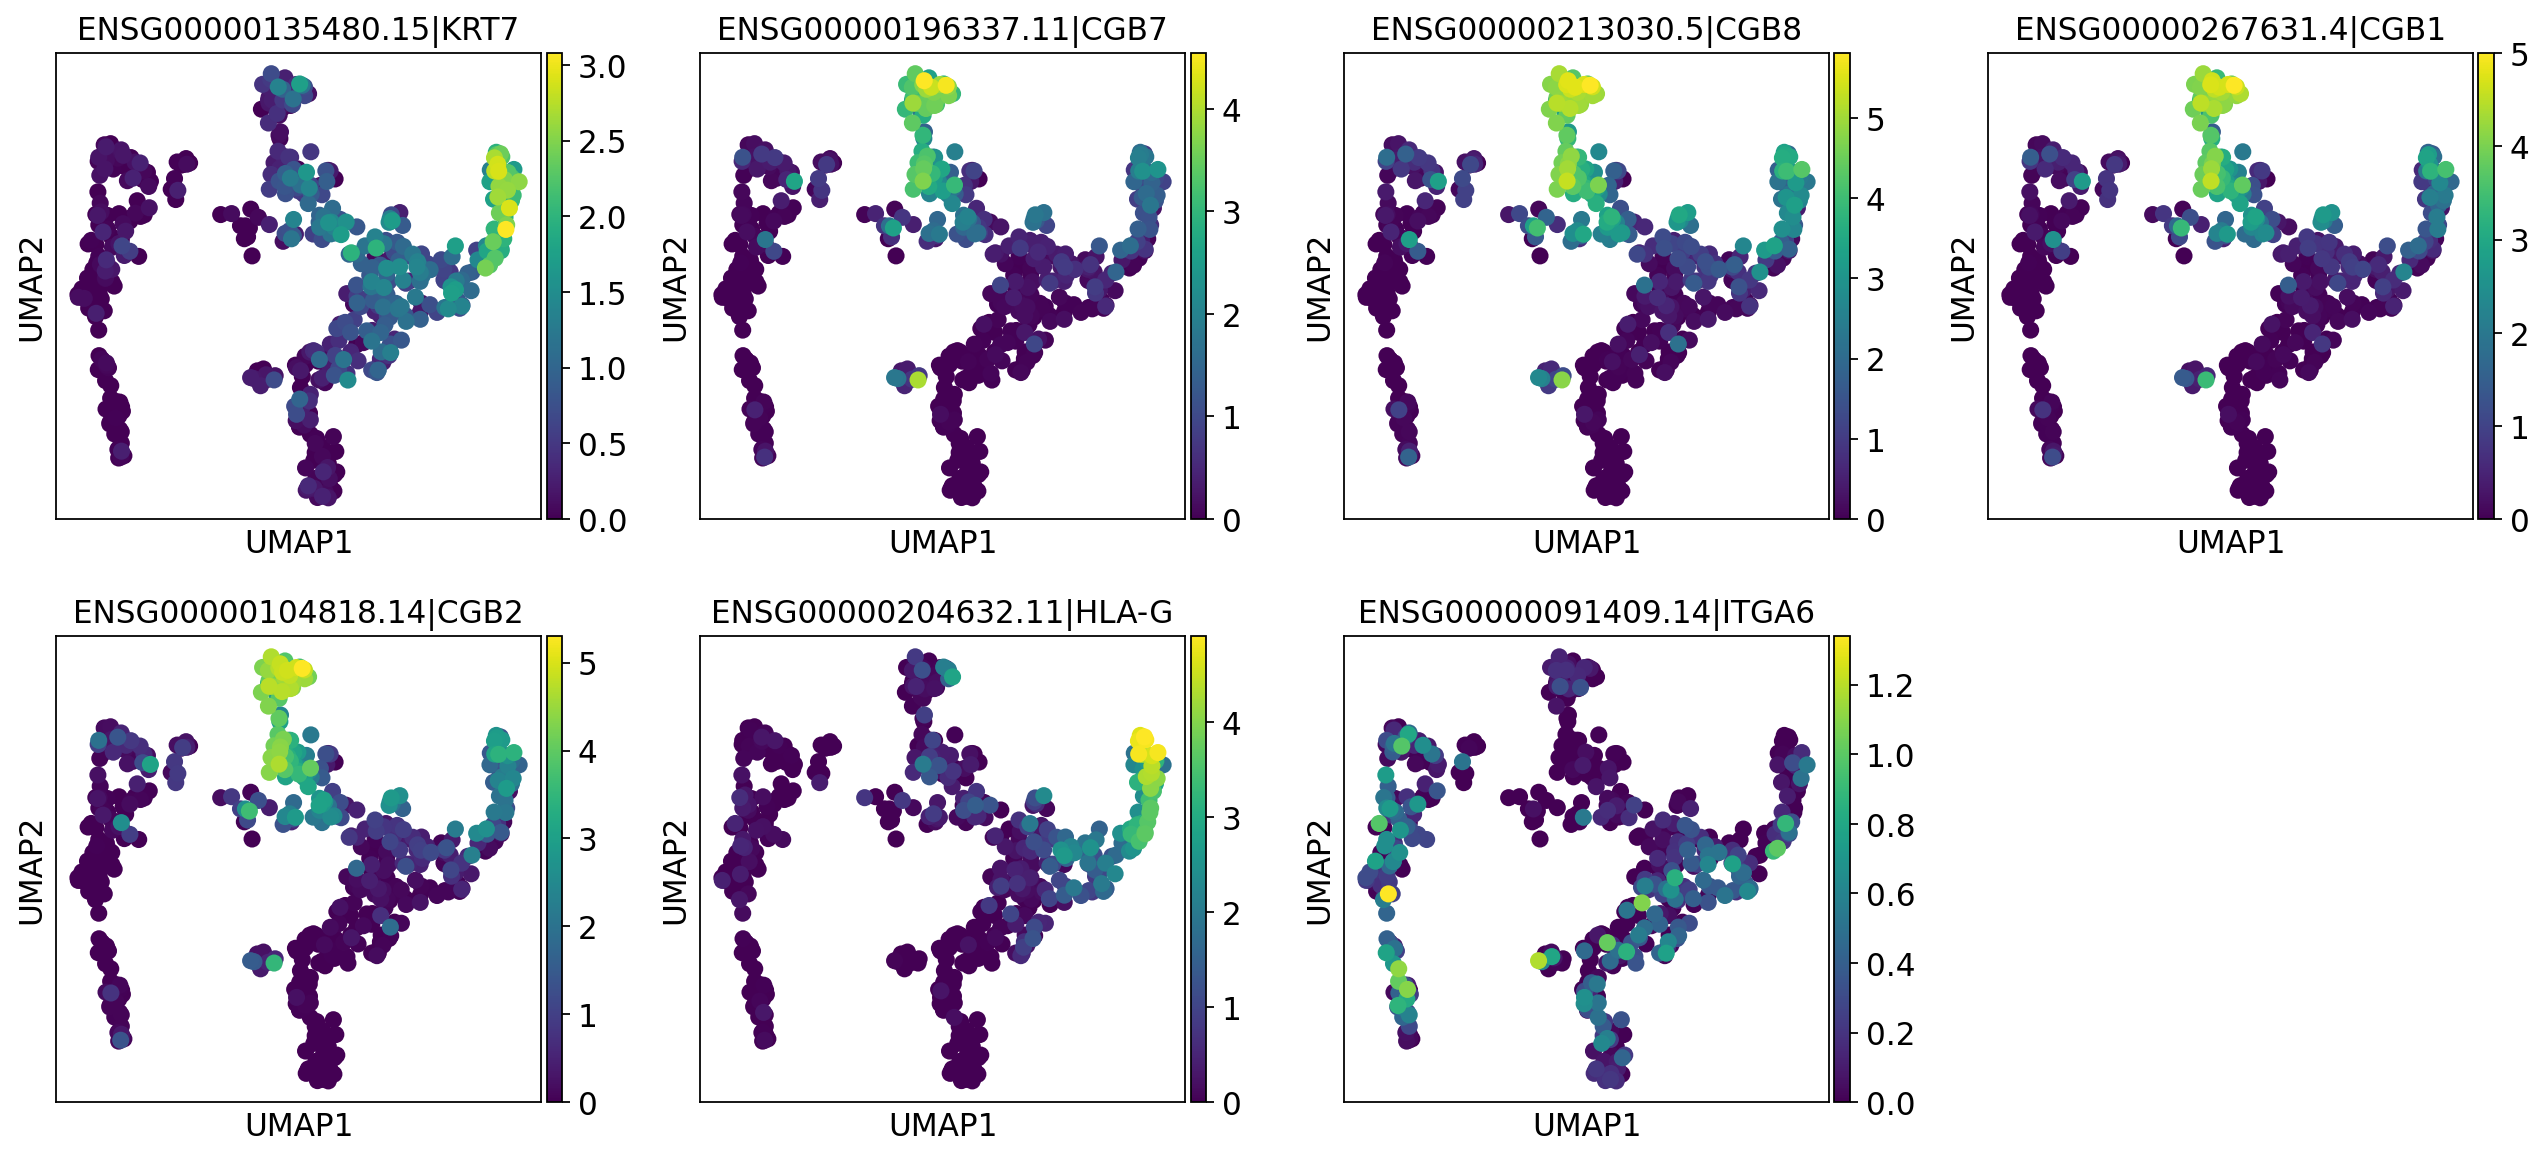

In [48]:
sc.pl.umap(adata,color=['ENSG00000135480.15|KRT7','ENSG00000196337.11|CGB7','ENSG00000213030.5|CGB8','ENSG00000267631.4|CGB1','ENSG00000104818.14|CGB2','ENSG00000204632.11|HLA-G','ENSG00000091409.14|ITGA6'])

Clustering

In [53]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 13 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/gpfs/gibbs/project/reilly/mcn26/conda_envs/parse_scanpy/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


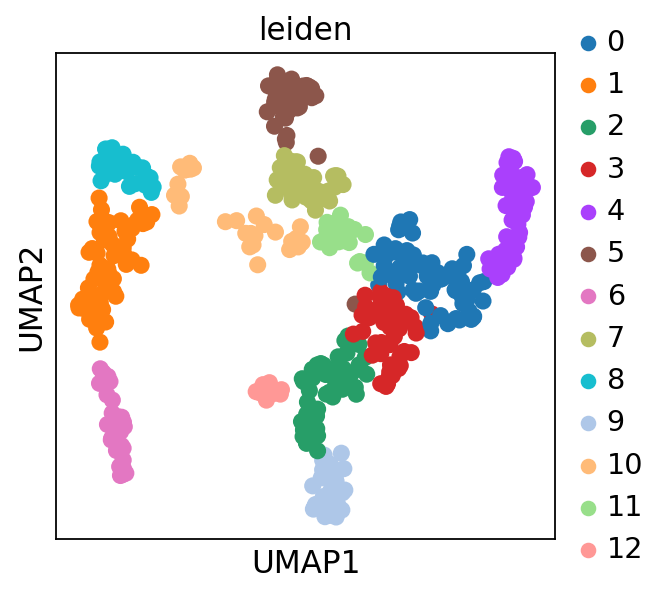

In [54]:
sc.pl.umap(adata, color=['leiden'])

8 & 1 : epiblast

6: hypoblast

0, 2, 7, 5, 4, 12, 11, 3 : trophoblast


In [58]:
cluster_merging_dict={
    '8':'Epiblast',
    '1':'Epiblast',
    '6':'Hypoblast',
    '0':'Trophoblast',
    '7':'Trophoblast',
    '5':'Trophoblast',
    '4':'Trophoblast',
    '12':'Trophoblast',
    '11':'Trophoblast',
    '2':'Trophoblast',
    '3':'Trophoblast'
}

adata.obs['leiden_merged'] = adata.obs['leiden'].copy()

adata.obs['leiden_merged']=adata.obs['leiden_merged'].replace(cluster_merging_dict)

/gpfs/gibbs/project/reilly/mcn26/conda_envs/parse_scanpy/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


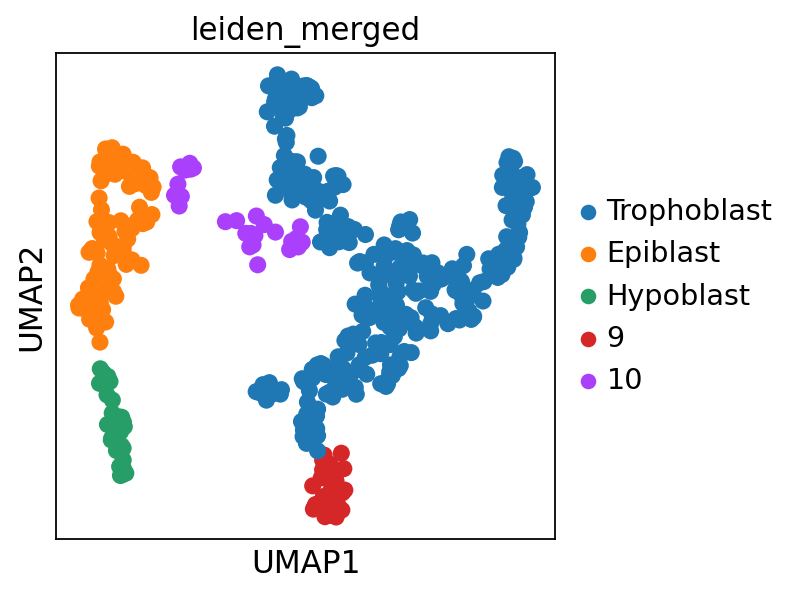

In [59]:
sc.pl.umap(adata, color=['leiden_merged'])

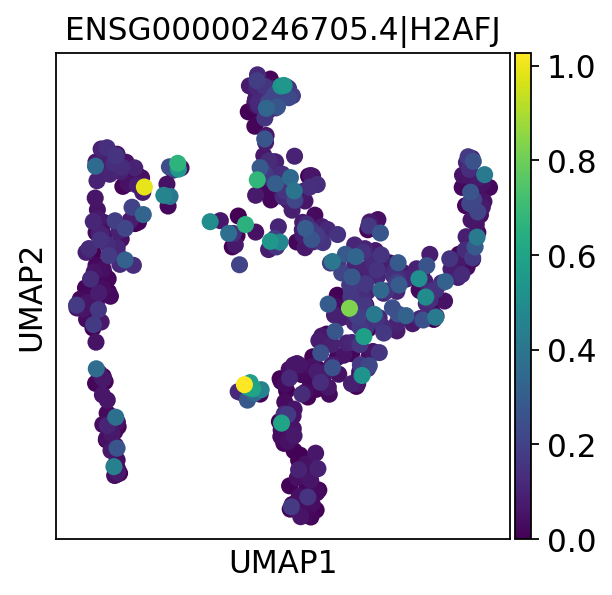

In [60]:
sc.pl.umap(adata, color=['ENSG00000246705.4|H2AFJ'])

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


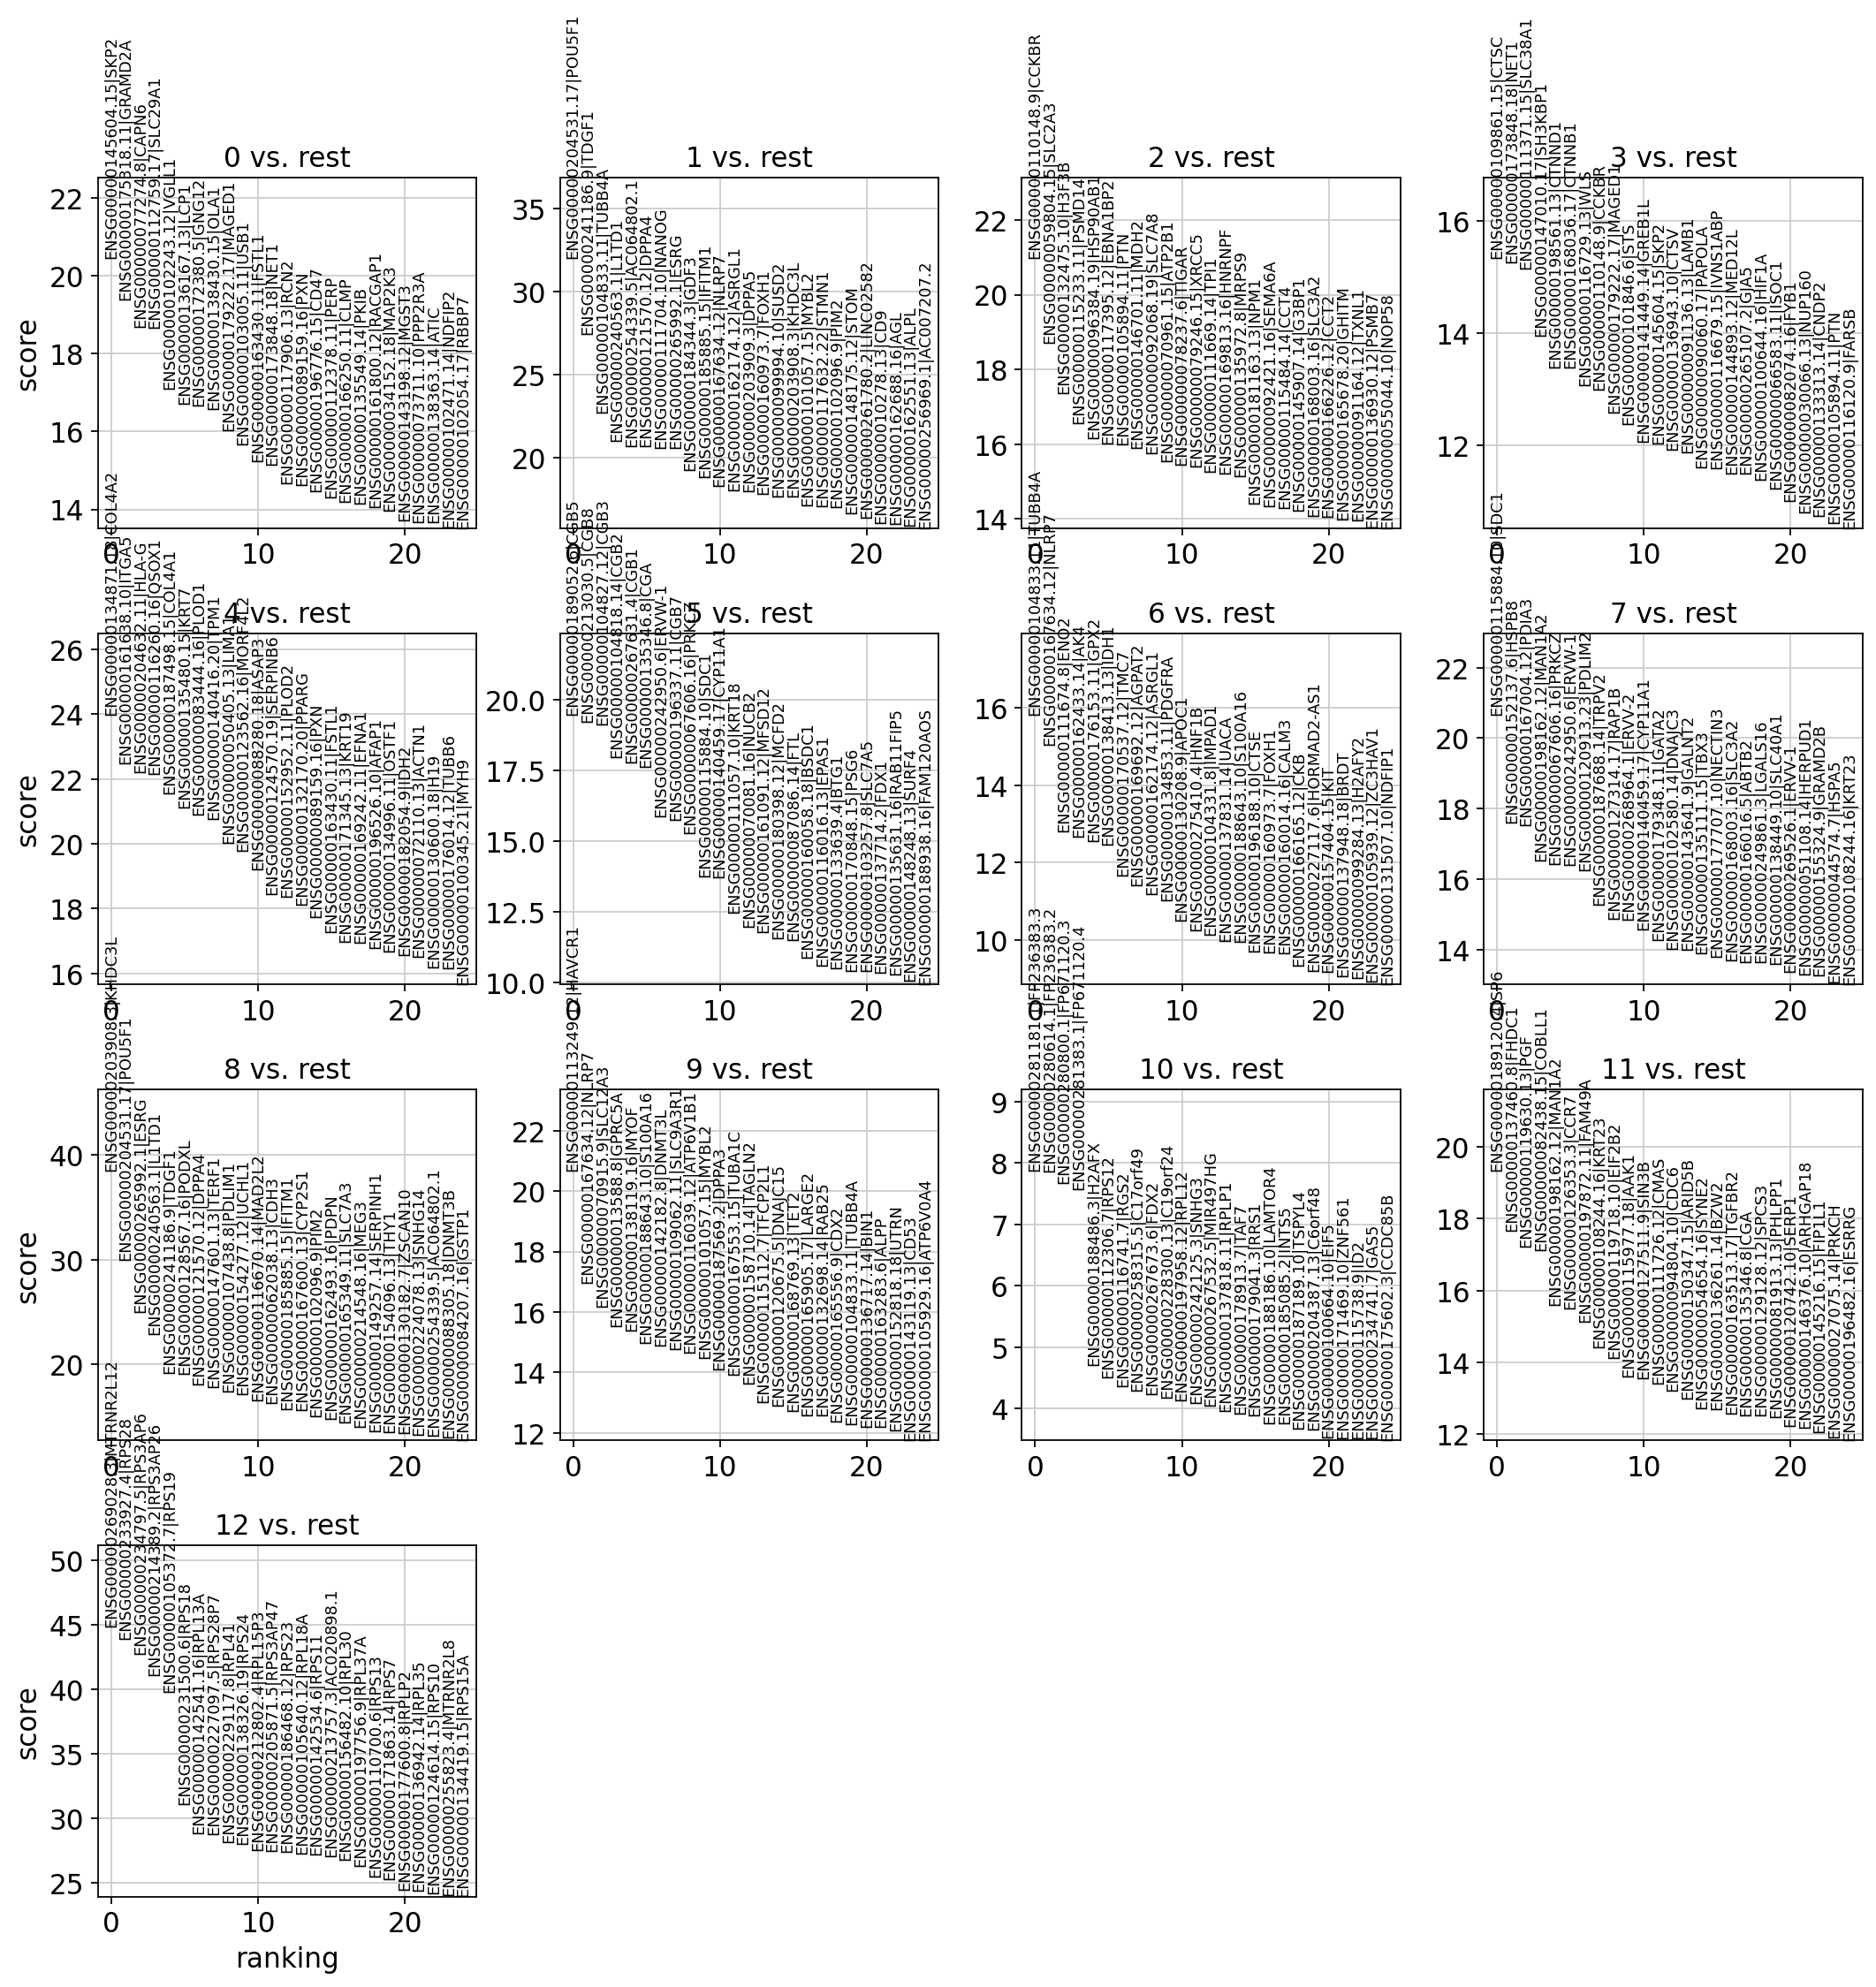

In [137]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

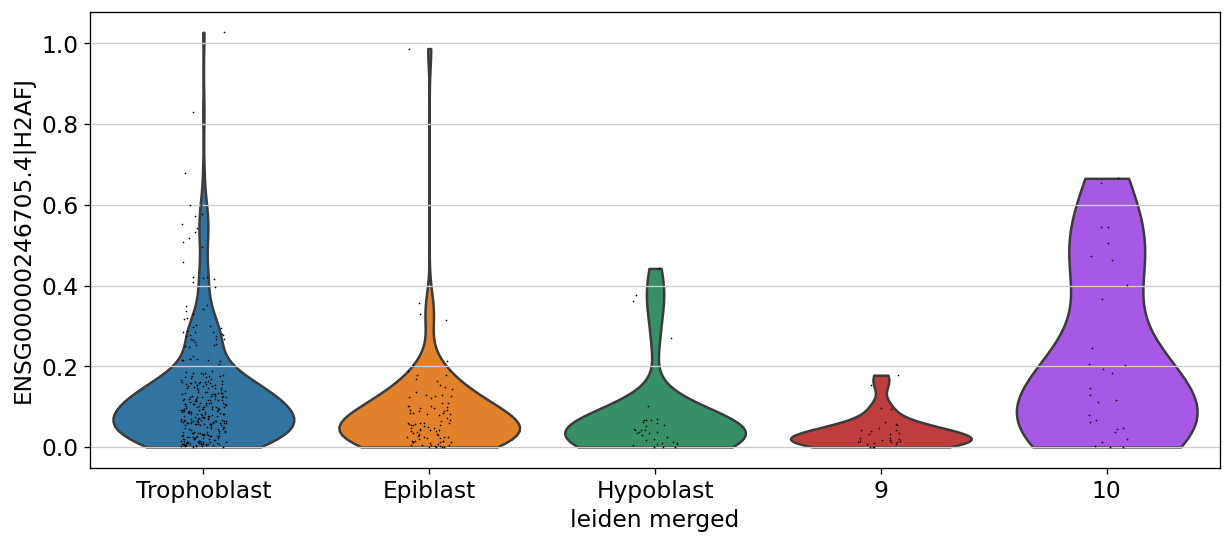

In [79]:
sc.settings.set_figure_params(dpi=60, facecolor='white',figsize=(10,5))
sc.pl.violin(adata, ['ENSG00000246705.4|H2AFJ'], groupby='leiden_merged',)

In [82]:
from scipy.stats import mannwhitneyu

Trophoblast = adata[adata.obs['leiden_merged'] == 'Trophoblast', 'ENSG00000246705.4|H2AFJ'].X
Hypoblast = adata[adata.obs['leiden_merged'] == 'Hypoblast', 'ENSG00000246705.4|H2AFJ'].X
Epiblast = adata[adata.obs['leiden_merged'] == 'Epiblast', 'ENSG00000246705.4|H2AFJ'].X

In [83]:
stat, p_val = mannwhitneyu(Trophoblast, Hypoblast)
print(p_val)

[1.11013799e-06]


In [85]:
stat, p_val = mannwhitneyu(Trophoblast, Epiblast)
print(p_val)

[6.28118907e-09]


In [87]:
stat, p_val = mannwhitneyu(Hypoblast, Epiblast)
print(p_val)

[0.23216518]


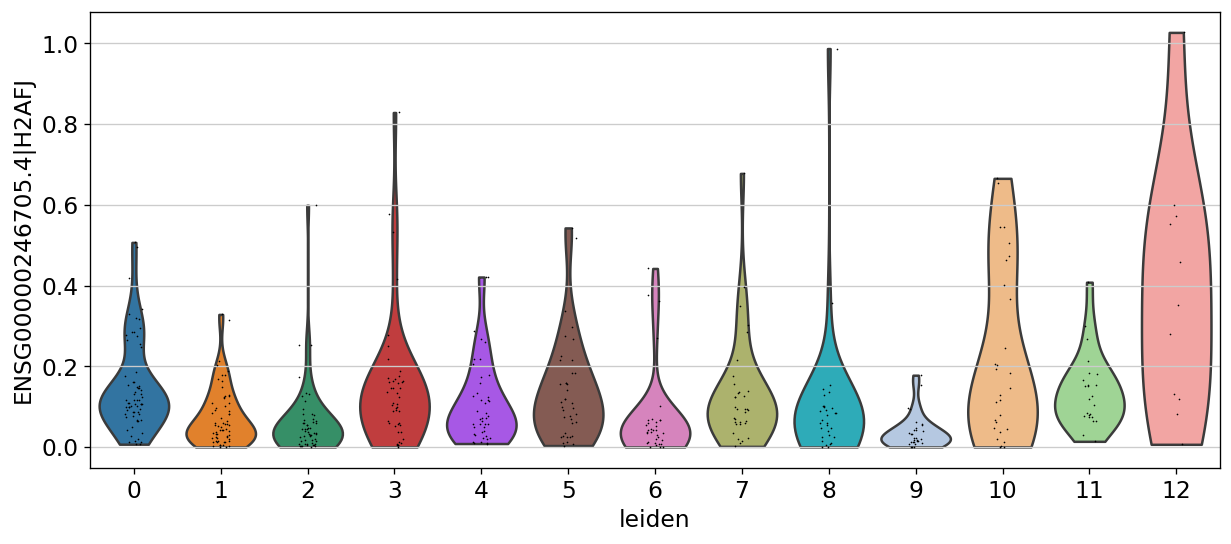

In [88]:
sc.pl.violin(adata, ['ENSG00000246705.4|H2AFJ'], groupby='leiden',)

In [90]:
sc.tl.rank_genes_groups(adata, groupby='leiden', groups=['12'], reference='rest', method='wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


{'params': {'groupby': 'leiden',
  'reference': 'rest',
  'method': 'wilcoxon',
  'use_raw': True,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('ENSG00000186468.12|RPS23',),
            ('ENSG00000232145.1|AC099548.1',),
            ('ENSG00000226038.5|PPIAP21',), ...,
            ('ENSG00000221411.1|MIR1227',), ('ENSG00000177156.10|TALDO1',),
            ('ENSG00000265401.1|AC093484.3',)],
           dtype=[('12', 'O')]),
 'scores': rec.array([( 5.676443 ,), ( 5.676443 ,), ( 5.676443 ,), ...,
            (-5.288115 ,), (-5.306804 ,), (-5.5310793,)],
           dtype=[('12', '<f4')]),
 'pvals': rec.array([(1.37524436e-08,), (1.37524436e-08,), (1.37524436e-08,), ...,
            (1.23583406e-07,), (1.11563784e-07,), (3.18266140e-08,)],
           dtype=[('12', '<f8')]),
 'pvals_adj': rec.array([(6.50737969e-07,), (6.50737969e-07,), (6.50737969e-07,), ...,
            (3.25264445e-06,), (2.95284258e-06,), (9.61600534e-07,)],
           dtype=[('12', '<f8

In [96]:
adata.uns['rank_genes_groups']#["names"].tolist()

{'params': {'groupby': 'leiden',
  'reference': 'rest',
  'method': 'wilcoxon',
  'use_raw': True,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('ENSG00000186468.12|RPS23',),
            ('ENSG00000232145.1|AC099548.1',),
            ('ENSG00000226038.5|PPIAP21',), ...,
            ('ENSG00000221411.1|MIR1227',), ('ENSG00000177156.10|TALDO1',),
            ('ENSG00000265401.1|AC093484.3',)],
           dtype=[('12', 'O')]),
 'scores': rec.array([( 5.676443 ,), ( 5.676443 ,), ( 5.676443 ,), ...,
            (-5.288115 ,), (-5.306804 ,), (-5.5310793,)],
           dtype=[('12', '<f4')]),
 'pvals': rec.array([(1.37524436e-08,), (1.37524436e-08,), (1.37524436e-08,), ...,
            (1.23583406e-07,), (1.11563784e-07,), (3.18266140e-08,)],
           dtype=[('12', '<f8')]),
 'pvals_adj': rec.array([(6.50737969e-07,), (6.50737969e-07,), (6.50737969e-07,), ...,
            (3.25264445e-06,), (2.95284258e-06,), (9.61600534e-07,)],
           dtype=[('12', '<f8

In [97]:
top_genes = adata.uns['rank_genes_groups']['names']["12"][:15]
print(top_genes)

['ENSG00000186468.12|RPS23' 'ENSG00000232145.1|AC099548.1'
 'ENSG00000226038.5|PPIAP21' 'ENSG00000235559.1|NOP56P1'
 'ENSG00000226624.1|AC005099.1' 'ENSG00000142534.6|RPS11'
 'ENSG00000235045.2|RPL7P8' 'ENSG00000249855.1|EEF1A1P19'
 'ENSG00000106803.9|SEC61B' 'ENSG00000244052.1|RPL5P24'
 'ENSG00000215807.4|KRT18P65' 'ENSG00000227063.5|RPL41P1'
 'ENSG00000267752.1|RPS10P27' 'ENSG00000090266.12|NDUFB2'
 'ENSG00000236552.2|RPL13AP5']


ENRICHR of top 15 (arbitrary) genes that are markers for the highest-expressing H2AJ cluster
https://maayanlab.cloud/Enrichr/enrich?dataset=3b7c77b778e9ee8a7d36bad8b79debb2

In [ ]:
expr_df = pd.DataFrame(adata.X, columns=adata.var_names)
gene_of_interest_expression = expr_df['ENSG00000246705.4|H2AFJ']
correlations = expr_df.corrwith(gene_of_interest_expression)
sorted_genes = correlations.sort_values(ascending=False)
sorted_genes
